<a href="https://colab.research.google.com/github/RafaelLambert/mpv-arquitetura-de-software-calssificador-de-vinhos/blob/main/vinho_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise e Predição da Qualidade do Vinho

### Nome: Rafael Marçal Lambert dos Santos

### MVP referente à sprint de Qualidade de Software

### Curso de Pós Graduação em Engenharia de Software

## Definição do Problema

O Objetivo desta análise é prever a qualidade de vinhos (brancos e tintos) com base e suas características físico-químicas, utilizando técnicas de aprendizado supervisionado.

### Tipo de problema

Este é um problema de classificação supervisionada, em que buscamos prever a variável "quality", referente à qualidade do vinho, com base em 11 atributos químicos e físicos da bebida.

## Dados

###Fonte:
 UCI Datasets - Wine Quality: https://archive.ics.uci.edu/dataset/186/wine+quality



### Descrição das Features:
O dataset é composto por 11 *features*:


1. fixed_acidity: ácido fixo (tartárico)
2. volatile_acidity: ácido acético (cheiro de vinagre)
3. citric_acid: ácido cítrico
4. residual_sugar: açúcar residual
5. chlorides: concentração de cloretos
6. free_sulfur_dioxide: dióxido de enxofre livre
7. total_sulfur_dioxide: dióxido de enxofre total
8. density: densidade do vinho
9. pH: acidez (potencial hidrogeniônico)
10. sulphates: sulfatos (contribuem para o sabor e conservação)
11. alcohol: teor alcoólico
12. quality: pontuação sensorial (0 a 10)

## Preparação dos Dados

## Importação das bibliotecas

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Carregamento de bibliotecas e dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.model_selection import RandomizedSearchCV # para otimização de hiperparâmetros
from sklearn.model_selection import GridSearchCV # para otimização de hiperparâmetros

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.linear_model import LogisticRegression # algoritmo Regressão Logística
from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Regressão
from sklearn.svm import SVC # algoritmo SVM
from sklearn.model_selection import cross_val_score # para executar a validação cruzada
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA # análise de componentes principais para redução de dimensionalidade
from sklearn.preprocessing import StandardScaler, MinMaxScaler # padronização dos dados
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report # métricas de avaliação
from sklearn.feature_selection import RFE # seleção de features baseada em regressão
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor # Métodos ensemble
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # otimização de hiperparâmetros
from scipy.stats import randint # para gerar números aleatórios

## Importação do Dataset:

In [ ]:
# Leitura dos arquivos CSV
vinho_tinto = pd.read_csv("winequality-red-training-test-model.csv", sep=',')
vinho_branco = pd.read_csv("winequality-white-training-test-model.csv", sep=',')

# Adiciona coluna "tipo"
vinho_tinto["tipo"] = "tinto"
vinho_branco["tipo"] = "branco"

# Une os dois datasets
df = pd.concat([vinho_tinto, vinho_branco], axis=0).reset_index(drop=True)

# Reorganiza as colunas para que "tipo" seja a primeira
cols = ['tipo'] + [col for col in df if col != 'tipo']
df = df[cols]

df.head(5)

,tipo,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,tinto,10.4,0.610,0.49,2.1,0.200,5.0,16.0,0.99940,3.16,0.63,8.40,3
1,tinto,10.4,0.440,0.42,1.5,0.145,34.0,48.0,0.99832,3.38,0.86,9.90,3
2,tinto,11.6,0.580,0.66,2.2,0.074,10.0,47.0,1.00080,3.25,0.57,9.00,3
3,tinto,6.7,0.760,0.02,1.8,0.078,6.0,12.0,0.99600,3.55,0.63,9.95,3
4,tinto,6.8,0.815,0.00,1.2,0.267,16.0,29.0,0.99471,3.32,0.51,9.80,3


## Exploração dos Dados:
Nesta seção, os dados foram analisados para entender a estrutura e as características principais.

Foram verificadas:
- Distribuições das variáveis: Usando histogramas e boxplots, possibilitando a identificação de outliers e assimetrias.
- Multicolinearidade: Heatmap de correlação foi utilizado para identificar relações fortes entre as variáveis preditoras.
- Análise de valores ausentes e duplicados: Garante a qualidade dos dados para modelagem.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6477 entries, 0 to 6476
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tipo                  6477 non-null   object 
 1   fixed acidity         6477 non-null   float64
 2   volatile acidity      6477 non-null   float64
 3   citric acid           6477 non-null   float64
 4   residual sugar        6477 non-null   float64
 5   chlorides             6477 non-null   float64
 6   free sulfur dioxide   6477 non-null   float64
 7   total sulfur dioxide  6477 non-null   float64
 8   density               6477 non-null   float64
 9   pH                    6477 non-null   float64
 10  sulphates             6477 non-null   float64
 11  alcohol               6477 non-null   float64
 12  quality               6477 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 657.9+ KB


In [ ]:
# Substituir espaços por underscores nos nomes das colunas
df.columns = df.columns.str.replace(' ', '_')

# Exibir os novos nomes das colunas
print("Nomes das colunas modificadas:")
print(df.columns)

Nomes das colunas modificadas:
Index(['tipo', 'fixed_acidity', 'volatile_acidity', 'citric_acid',
       'residual_sugar', 'chlorides', 'free_sulfur_dioxide',
       'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')


In [ ]:
# Ajustar o tipo de dados das colunas
df["free_sulfur_dioxide"] = df["free_sulfur_dioxide"].astype(int)
df["total_sulfur_dioxide"] = df["total_sulfur_dioxide"].astype(int)

# Verificar se foi alterado corretamente
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6477 entries, 0 to 6476
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tipo                  6477 non-null   object 
 1   fixed_acidity         6477 non-null   float64
 2   volatile_acidity      6477 non-null   float64
 3   citric_acid           6477 non-null   float64
 4   residual_sugar        6477 non-null   float64
 5   chlorides             6477 non-null   float64
 6   free_sulfur_dioxide   6477 non-null   int64  
 7   total_sulfur_dioxide  6477 non-null   int64  
 8   density               6477 non-null   float64
 9   pH                    6477 non-null   float64
 10  sulphates             6477 non-null   float64
 11  alcohol               6477 non-null   float64
 12  quality               6477 non-null   int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 657.9+ KB


In [ ]:
#Verifica dados nulos
null_quantity = df.isnull().sum().sum()
print(f"Quantidade de dados nulos: {null_quantity}")

#Verifica linhas duplicadas
duplicated_quantity = df.duplicated().sum()
print(f"Quantidade de linhas duplicadas: {duplicated_quantity}")

#Verifica linhas duplicadas
df.duplicated().sum()

#Remove duplicadas
df = df.drop_duplicates()

#Verifica se as duplicadas foram removidas
duplicated_quantity = df.duplicated().sum()
print(f"Quantidade de linhas duplicadas: {duplicated_quantity}")

Quantidade de dados nulos: 0
Quantidade de linhas duplicadas: 1177
Quantidade de linhas duplicadas: 0


In [ ]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,5300.000000,5300.000000,5300.000000,5300.000000,5300.000000,5300.000000,5300.00000,5300.000000,5300.000000,5300.000000,5300.000000,5300.000000
mean,7.213557,0.344043,0.318328,5.052585,0.056713,30.066981,114.22000,0.994537,3.224475,0.533364,10.546691,5.795849
std,1.314068,0.168066,0.146902,4.503822,0.036907,17.802142,56.76009,0.002964,0.160216,0.149763,1.184049,0.874359
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.00000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,75.00000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.00000,0.994665,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,154.00000,0.996762,3.330000,0.600000,11.400000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.00000,1.038980,4.010000,2.000000,14.900000,9.000000


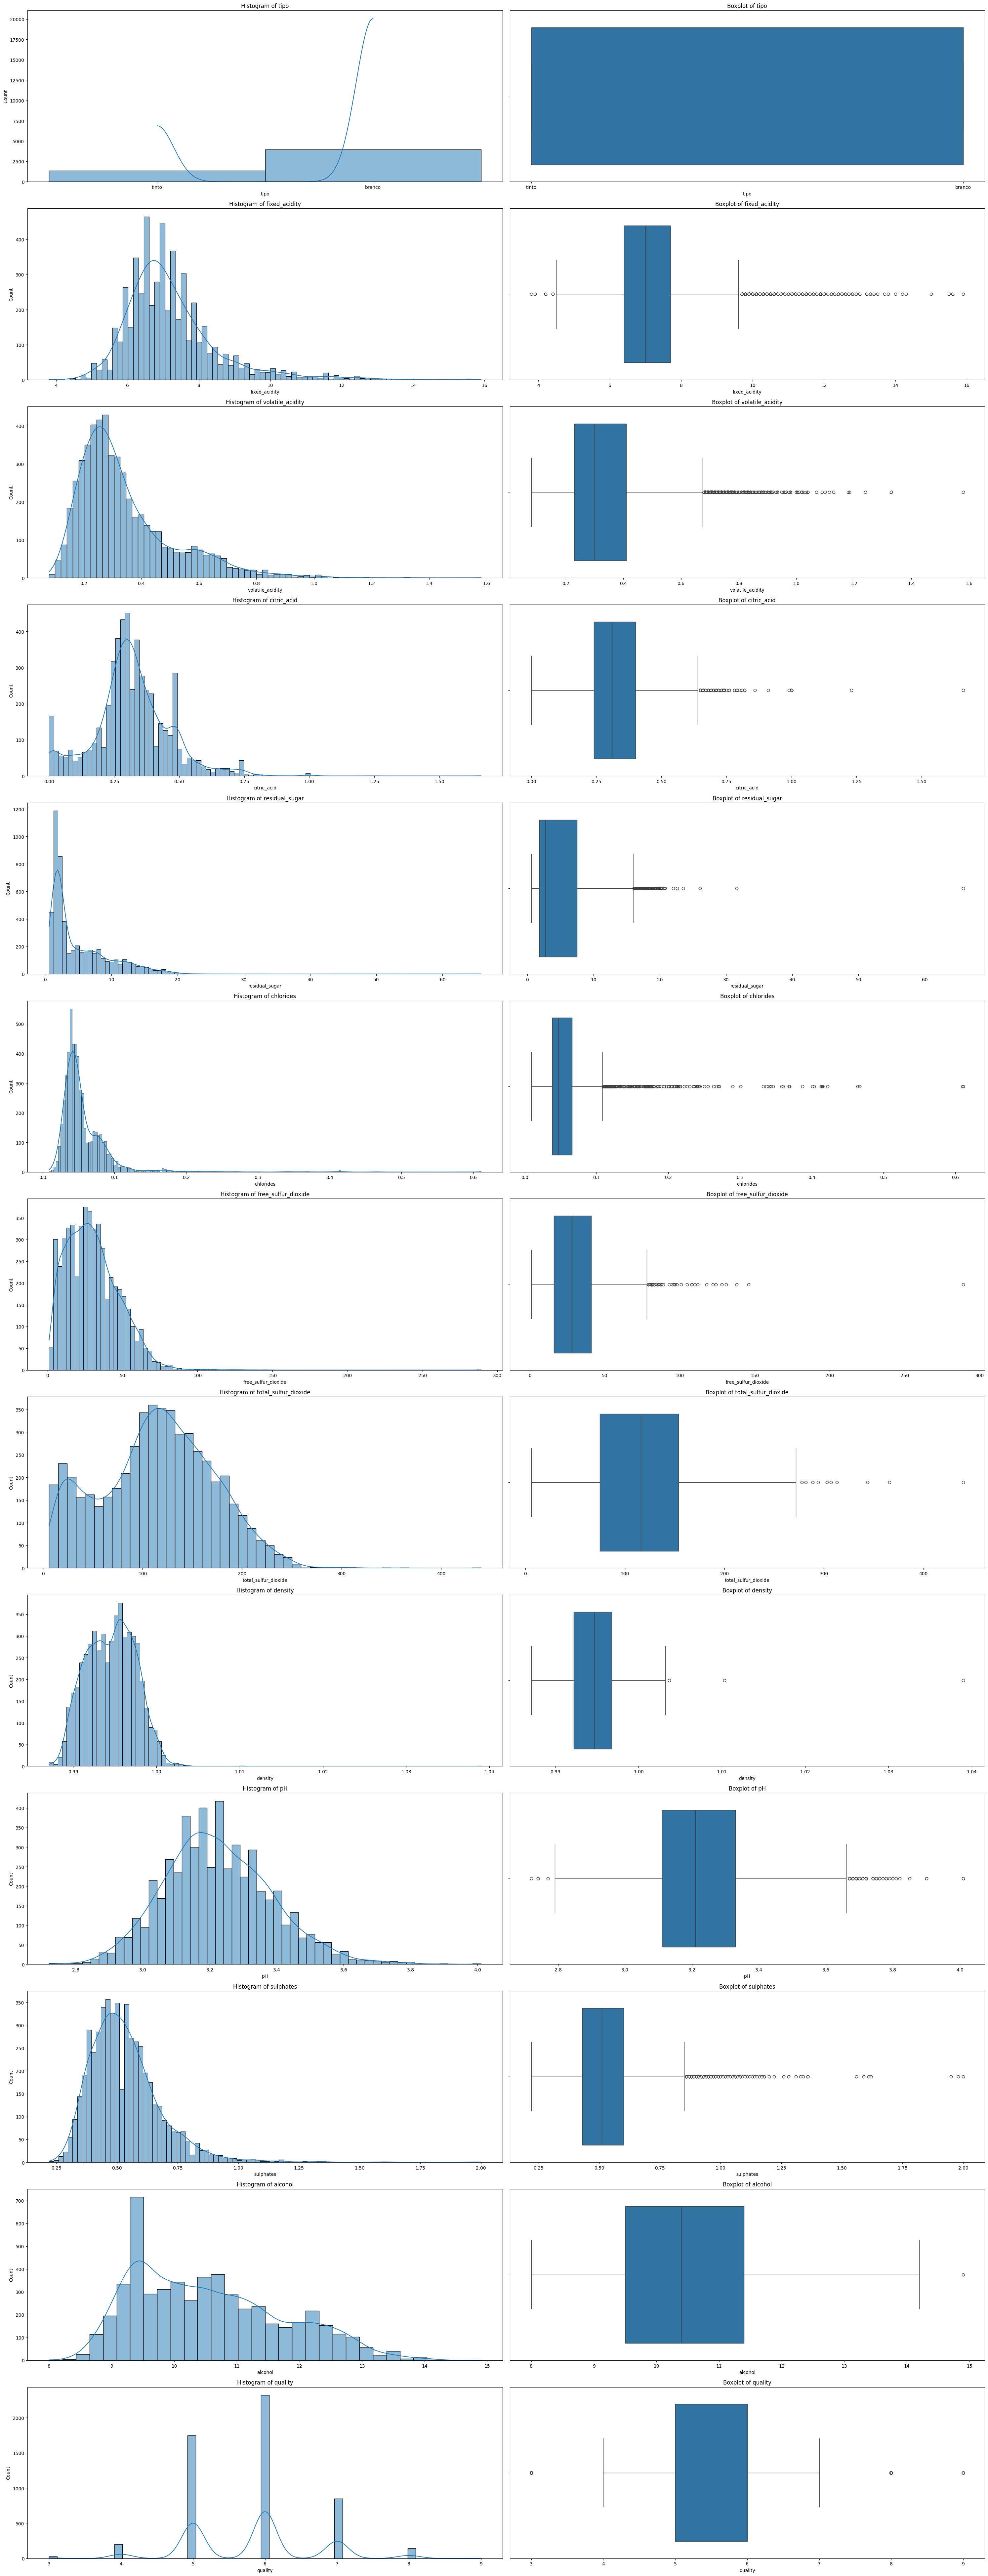

In [ ]:
n_columns = len(df.columns)
fig, ax = plt.subplots(nrows=n_columns, ncols=2, figsize=(30, 6 * n_columns))

for i, column in enumerate(df.columns):
    # Histograma
    sns.histplot(data=df, x=column, kde=True, ax=ax[i, 0])
    ax[i, 0].set_title(f'Histogram of {column}')

    # Boxplot
    sns.boxplot(data=df, x=column, ax=ax[i, 1])
    ax[i, 1].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

Conluímos que o data set é muito desbalanceado!

In [ ]:
# selecionando apenas as colunas numéricas

df_numeric = df.iloc[:, 1:]

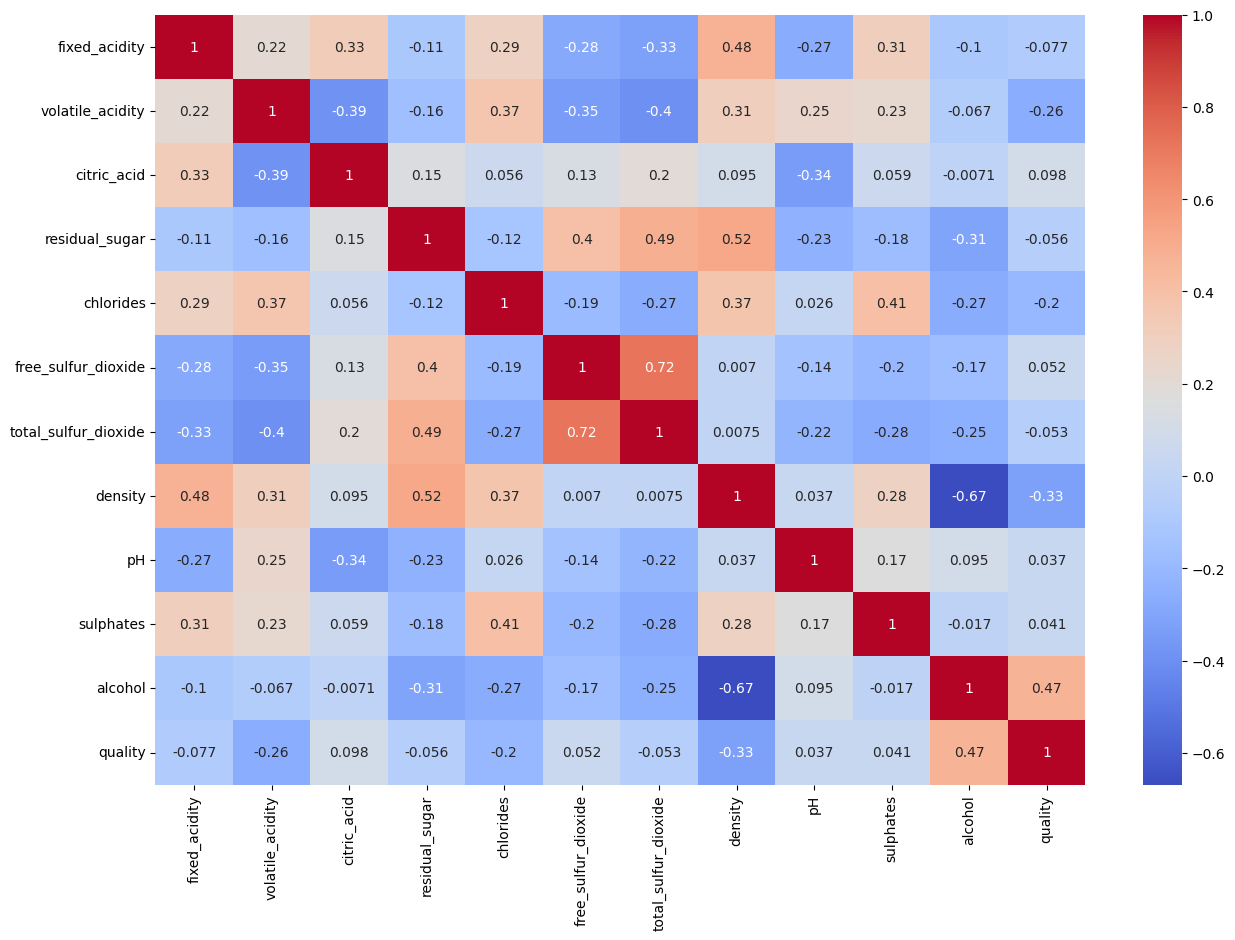

In [ ]:
# Checando multicolinearidade com Heatmap de correlação

plt.figure(figsize=(15, 10))
correlation_matrix = df_numeric.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

A multicolinearidade pode complicar a construção e interpretação dos modelos.

## Pré processamento

In [ ]:
# One-hot encoding para o tipo de vinho
df = pd.get_dummies(df, columns=["tipo"], drop_first=True)

In [ ]:
# Conversão da variável target para classificação categórica
def map_quality(q):
    if q <= 4:
        return 0  # ruim
    elif q <= 6:
        return 1  # razoável
    elif q <= 7:
        return 2  # bom
    else:
        return 3  # excelente

df['qualidade_category'] = df['quality'].apply(map_quality)

In [ ]:
# Contar a ocorrência de cada categoria
category_counts = df['qualidade_category'].value_counts().sort_index()

# Calcular o percentual relativo ao total de linhas
category_percentages = (category_counts / len(df)) * 100

# Exibir os resultados
result = pd.DataFrame({
    'Contagem': category_counts,
    'Percentual (%)': category_percentages
})

print(result)

                    Contagem  Percentual (%)
qualidade_category                          
0                        230        4.339623
1                       4069       76.773585
2                        852       16.075472
3                        149        2.811321


### Tetantiva de equalizar os dados

####Undersampling
Foi Aplicado este método para tentar equalizar mais os dados. entretanto ao aplicar este método a acuracia cai em mais de 10%


In [ ]:
from sklearn.utils import resample

# Divide o dataframe por classe
df_0 = df[df['qualidade_category'] == 0]
df_1 = df[df['qualidade_category'] == 1]
df_2 = df[df['qualidade_category'] == 2]
df_3 = df[df['qualidade_category'] == 3]

# Downsample da classe 1 (para equiparar com a menor, classe 3 ou a média)
df_1_downsampled = resample(df_1, replace=False, n_samples=300, random_state=42)  # Mesmo tamanho da classe 2
df_2_downsampled = resample(df_2, replace=False, n_samples=303, random_state=42)  # Mesmo tamanho da classe 2

# Junta tudo
df_balanceado = pd.concat([df_0, df_1_downsampled, df_2_downsampled, df_3])

# Contar a ocorrência de cada categoria
category_counts = df_balanceado['qualidade_category'].value_counts().sort_index()

# Calcular o percentual relativo ao total de linhas
category_percentages = (category_counts / len(df_balanceado)) * 100

# Exibir os resultados
result = pd.DataFrame({
    'Contagem': category_counts,
    'Percentual (%)': category_percentages
})

df=df_balanceado

print(result)


####Smote
Foi Aplicado este método para tentar equalizar mais os dados.


In [ ]:
from imblearn.over_sampling import SMOTE

X = df.drop("qualidade_category", axis=1)
y = df["qualidade_category"]

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# (opcional) Criar novo DataFrame balanceado
df_balanceado = pd.DataFrame(X_resampled, columns=X.columns)
df_balanceado["qualidade_category"] = y_resampled

# Contar a ocorrência de cada categoria
category_counts = df_balanceado['qualidade_category'].value_counts().sort_index()

# Calcular o percentual relativo ao total de linhas
category_percentages = (category_counts / len(df_balanceado)) * 100

# Exibir os resultados
result = pd.DataFrame({
    'Contagem': category_counts,
    'Percentual (%)': category_percentages
})

df=df_balanceado

print(result)

                    Contagem  Percentual (%)
qualidade_category                          
0                       4069            25.0
1                       4069            25.0
2                       4069            25.0
3                       4069            25.0


### Separação dos Dados em conjunto de treino e conjunto de teste com holdout:
Dividindo o dataset entre conjuntos de treino e teste - 80/20

In [ ]:
# Separando features e target
X = df.drop(['quality', 'qualidade_category'], axis=1)
y = df['qualidade_category']

In [ ]:
# Divisão em treino e teste
test_size = 0.20 #tamanho do conjunto de teste
seed = 7 # semente aleatória

#Serparação dos conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed, stratify=y) #holdout com estratificação

#Parâmetros e partições da validação cruzada
scoring = 'accuracy' #métrica de avaliação
num_particoes = 5 #número de partições
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) #validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.783871 (0.003037)
CART: 0.789094 (0.007260)
NB: 0.460753 (0.011323)
SVM: 0.452151 (0.002667)


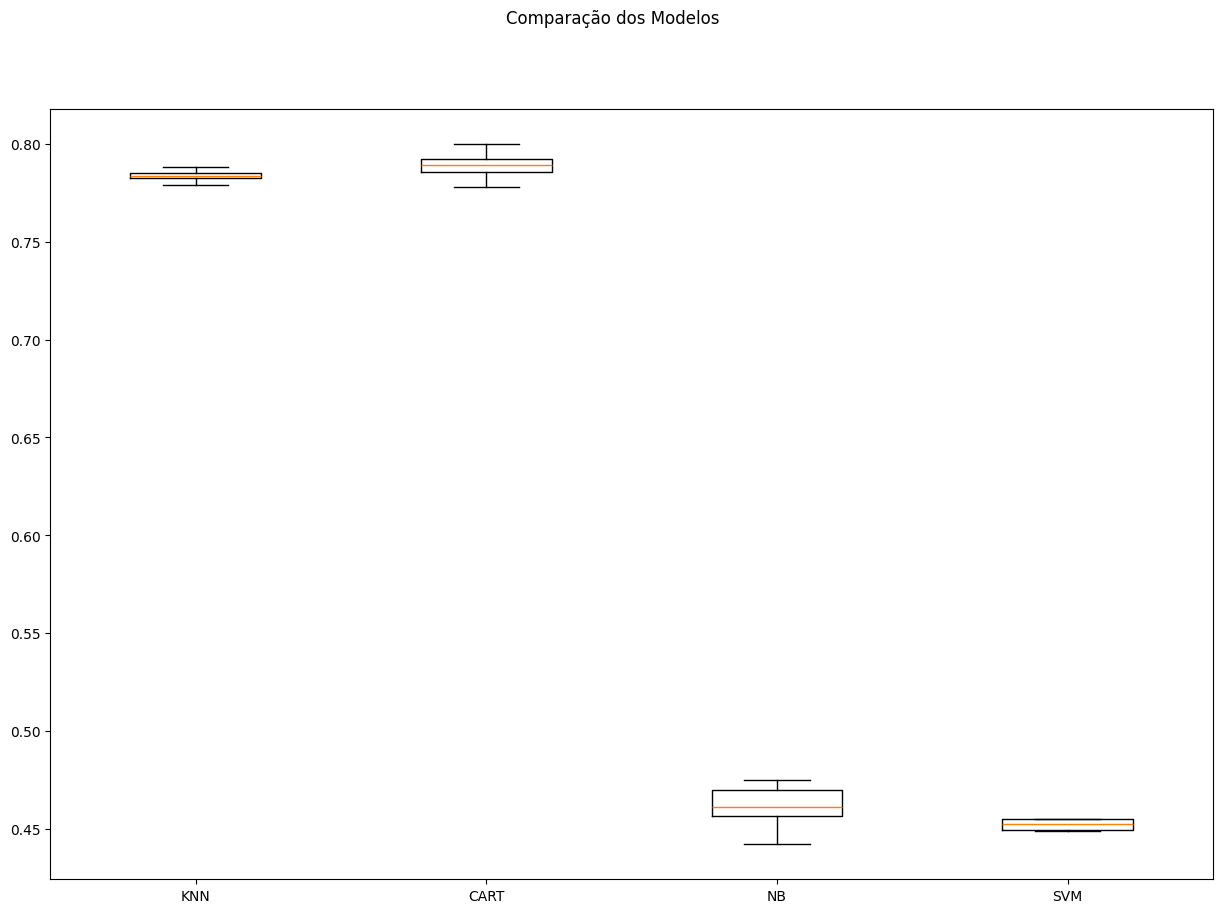

In [ ]:
np.random.seed(seed) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.784 (0.003)
CART-orig: 0.789 (0.007)
NB-orig: 0.461 (0.011)
SVM-orig: 0.452 (0.003)
KNN-padr: 0.819 (0.001)
CART-padr: 0.786 (0.008)
NB-padr: 0.463 (0.011)
SVM-padr: 0.711 (0.008)
KNN-norm: 0.809 (0.005)
CART-norm: 0.787 (0.005)
NB-norm: 0.463 (0.011)
SVM-norm: 0.635 (0.009)


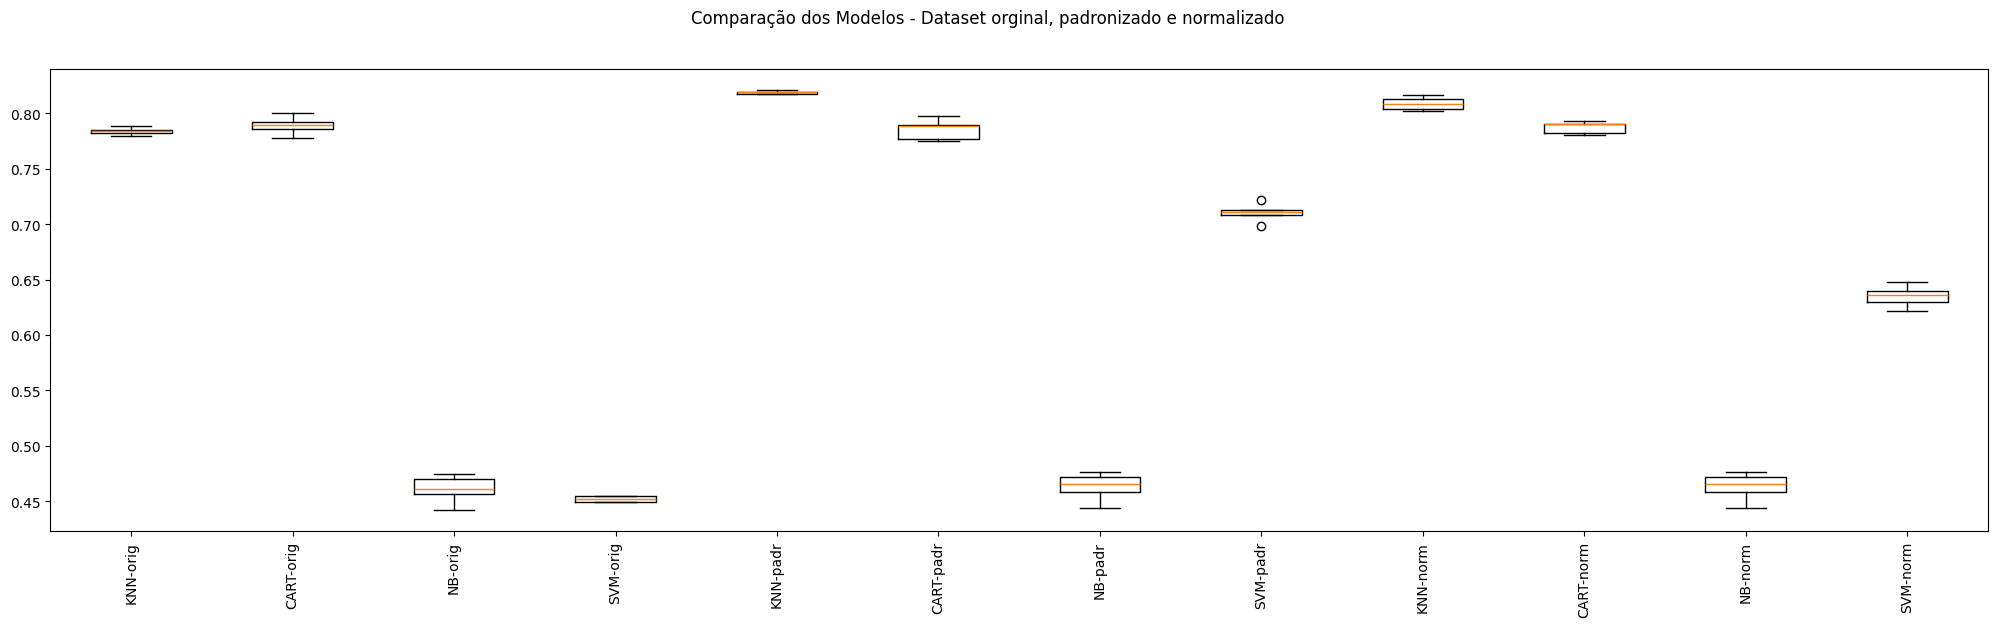

In [ ]:
np.random.seed(seed) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [ ]:
# Tuning do SVM
np.random.seed(seed)  # Semente global

pipelines = []

# Componentes
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Pipelines com diferentes pré-processamentos
pipelines.append(('svm-orig', Pipeline(steps=[svm])))
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))
pipelines.append(('svm-norm', Pipeline(steps=[min_max_scaler, svm])))

# Espaço de busca de hiperparâmetros
param_grid = {
    'SVM__C': [0.1, 1, 10, 100],
    'SVM__kernel': ['linear', 'rbf', 'poly'],
    'SVM__gamma': ['scale', 'auto']
}

# GridSearchCV para cada pipeline
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
    grid.fit(X_train, y_train)
    print(f"{name} - Melhor Acurácia: {grid.best_score_:.3f} usando {grid.best_params_}")

O Código acima ficou muito pesado para rodar todos o modelos (comum, normalizado e padronizado) levando mais de 3 horas para executar o treino. Assim optarei por verificar a otmização de modelo apenas com o SVM Padronizado que até o memento trouxe a melhor acuracia.

In [ ]:
# Tuning do SVM
np.random.seed(seed)  # Semente global

pipelines = []

# Componentes
standard_scaler = ('StandardScaler', StandardScaler())

# Pipelines com diferentes pré-processamentos
pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))

# Espaço de busca de hiperparâmetros
param_grid = {
    'SVM__C': [0.1, 1, 10, 100],
    'SVM__kernel': ['linear', 'rbf', 'poly'],
    'SVM__gamma': ['scale', 'auto']
}

# GridSearchCV para cada pipeline
for name, model in pipelines:
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10,scoring=scoring, cv=kfold, n_jobs=-1,random_state=seed)
    grid.fit(X_train, y_train)
    print(f"{name} - Melhor Acurácia: {grid.best_score_:.3f} usando {grid.best_params_}")

svm-padr - Melhor Acurácia: 0.793 usando {'SVM__kernel': 'rbf', 'SVM__gamma': 'scale', 'SVM__C': 10}


No caso o hiper parâmetro não trouxe uma melhora real para acuracia, assim seguierei com SVM sem tais parâmetros.

## Finalização do Modelo

### Modelo SVM com padronização

Este será o modelo utilizado pelo back end

In [ ]:
# 1. Treinar o scaler e o modelo
scaler_std = StandardScaler().fit(X_train)
rescaledX_std = scaler_std.transform(X_train)

model_std_final = SVC(C=10, kernel='rbf', gamma='scale')
model_std_final.fit(rescaledX_std, y_train)

SVC(C=10)

In [ ]:
# Preparação do modelo com TODO o dataset
scaler_std = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX_std = scaler_std.transform(X) # aplicação da padronização com TODO o dataset
model_std_final.fit(rescaledX_std, y)

#### Esstatísticas do SVM PADRONIZADO final

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Estimativa da acurácia no conjunto de teste
rescaledTestX_std = scaler_std.transform(X_test) # aplicação da padronização no conjunto de teste
predictions_std = model_std_final.predict(rescaledTestX_std)
print(accuracy_score(y_test, predictions_std))

# 1. Avaliação geral
print("Acurácia geral:", accuracy_score(y_test, predictions_std))

# 2. Relatório de classificação
print("\nRelatório por classe:")
print(classification_report(y_test, predictions_std))

# 3. Matriz de confusão
conf_matrix = confusion_matrix(y_test, predictions_std)
print("\nMatriz de Confusão:")
print(conf_matrix)

# 4. Porcentagem de acertos por classe
labels = np.unique(y_test)  # [0, 1, 2, 3]
acertos_por_classe = []

for i, label in enumerate(labels):
    total = conf_matrix[i].sum()
    acertos = conf_matrix[i, i]
    percentual = (acertos / total) * 100 if total > 0 else 0
    acertos_por_classe.append((label, total, acertos, percentual))

# Mostra a tabela de acertos por classe
df_resultado = pd.DataFrame(acertos_por_classe, columns=["Classe", "Total", "Acertos", "Acurácia (%)"])
print("\nAcertos por classe:")
print(df_resultado)


0.8046683046683046
Acurácia geral: 0.8046683046683046

Relatório por classe:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       814
           1       0.83      0.63      0.72       814
           2       0.72      0.74      0.73       814
           3       0.80      0.91      0.85       814

    accuracy                           0.80      3256
   macro avg       0.81      0.80      0.80      3256
weighted avg       0.81      0.80      0.80      3256


Matriz de Confusão:
[[766  39   5   4]
 [102 515 158  39]
 [ 13  60 601 140]
 [  4   3  69 738]]

Acertos por classe:
   Classe  Total  Acertos  Acurácia (%)
0       0    814      766     94.103194
1       1    814      515     63.267813
2       2    814      601     73.832924
3       3    814      738     90.663391


### Modelo SVM com normalização
Será utilizado para testagem de modelo no Back End

In [ ]:
# 1. Treinar o scaler e o modelo
scaler_norm = MinMaxScaler().fit(X_train)
rescaledX_norm = scaler_norm.transform(X_train)

model_norm_final = SVC()
model_norm_final.fit(rescaledX_norm, y_train)

SVC()

In [ ]:
# Estimativa da acurácia no conjunto de teste
rescaledTestX_norm = scaler_norm.transform(X_test)
predictions_norm = model_norm_final.predict(rescaledTestX_norm)
print(accuracy_score(y_test, predictions_norm))

In [ ]:

# Preparação do modelo com TODO o dataset
scaler_norm = MinMaxScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX_norm = scaler_norm.transform(X) # aplicação da padronização com TODO o dataset
model_norm_final.fit(rescaledX_norm, y)

In [ ]:
print(df.info())

#Exportando modelo e dados para aplicação no Back End

##Modelo

In [ ]:
import joblib

# Salvar modelos
joblib.dump(model_std_final, 'modelo_svm_std.pkl')
joblib.dump(model_norm_final, 'modelo_svm_norm.pkl')

# Salvar scaler (importante para usar a mesma padronização no backend)
joblib.dump(scaler_std, 'scaler_std.pkl')
joblib.dump(scaler_norm, 'scaler_norm.pkl')


['scaler_norm.pkl']

In [ ]:
from google.colab import files

files.download('modelo_svm_std.pkl')
files.download('modelo_svm_norm.pkl')
files.download('scaler_std.pkl')
files.download('scaler_norm.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Test

In [ ]:
# 1. Transformar o X_test e X completo com normalização
rescaledTestX_std = scaler_std.transform(X_test)   # X_test padronizado
rescaledTestX_norm = scaler_norm.transform(X_test) # X completo normalizado

# 2. Exportar o X_test padronizado
import pandas as pd
rescaledTestX_std_df = pd.DataFrame(rescaledTestX_std, columns=X_test.columns)
rescaledTestX_std_df.to_csv("x_test_scaled.csv", index=False)

# 3. Exportar o X completo normalizado
rescaledX_norm_df = pd.DataFrame(rescaledTestX_norm, columns=X.columns)
rescaledX_norm_df.to_csv("x_test_normalized.csv", index=False)

# 4. Exportar o y_test (rótulos esperados para avaliação posterior)
y_test_df = pd.DataFrame({'qualidade_category': y_test})
y_test_df.to_csv("y_test.csv", index=False)



In [ ]:
# 5. Baixar os arquivos
from google.colab import files
files.download("x_test_scaled.csv")
files.download("x_test_normalized.csv")
files.download("y_test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Simulando a aplicação do modelo em dados não vistos

In [ ]:
# 1. Selecionar apenas as colunas numéricas usadas no modelo (sem 'quality' e sem 'tipo_tinto')
atributos = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
             'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide',
             'density', 'pH', 'sulphates', 'alcohol','tipo_tinto']

df_numerico = df[atributos]

# 2. Gerar dados sintéticos dentro dos limites observados
n_amostras = 3
dados_ficticios = {}

# Gerar valores contínuos dentro do intervalo de cada atributo
for coluna in atributos:
    min_val = df[coluna].min()
    max_val = df[coluna].max()
    dados_ficticios[coluna] = np.random.uniform(min_val, max_val, n_amostras).round(3)

# 3. Criar DataFrame de entrada
entrada = pd.DataFrame(dados_ficticios, columns=atributos)

# 4. Transformar (padronizar ou normalizar) usando o mesmo scaler do treino
# Exemplo: se você usou StandardScaler
rescaled_entrada = scaler.transform(entrada)

# 5. Prever com o modelo treinado
predicoes = model.predict(rescaled_entrada)

# Exibir resultados
print("Novas amostras:\n", entrada)
print("Predições do modelo:", predicoes)

In [ ]:
# Novos dados - não sabemos a classe!
data = {'preg':  [1, 9, 5],
        'plas': [90, 100, 110],
        'pres': [50, 60, 50],
        'skin': [30, 30, 30],
        'test': [100, 100, 100],
        'mass': [20.0, 30.0, 40.0],
        'pedi': [1.0, 2.0, 1.0],
        'age': [15, 40, 40],
        }

atributos = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:8].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)